# Overview of this jupyter notebook

1. Loading data
2. Transforming data (normalization, shuffle)
3. Searching optimal 1D-CNN structure
4. Visualization of the searching results

In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_util as cu  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(cu))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\classification_util.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


## 1. Loading data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature = np.load('feature_label/feature_single_v4.1.npy')
feature.shape

(1600, 920)

In [7]:
label = np.load("feature_label/label_single_v4.1.npy")
label = to_categorical(label)
label.shape

(1600, 8)

## 2. Transforming data (normalization, shuffle)

In [8]:
# normalize the fature by dividing max value of feature

max_feat = np.max(feature)
feature_scaled = feature / max_feat

print(max_feat, feature_scaled.shape)

2.56704 (1600, 920)


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_scaled, label, random_state=13, test_size=0.25, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test)

(1200, 920)
(1200, 8)
(400, 920)
(400, 8)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
x_train_inverse = x_train*max_feat
x_test_inverse = x_test*max_feat

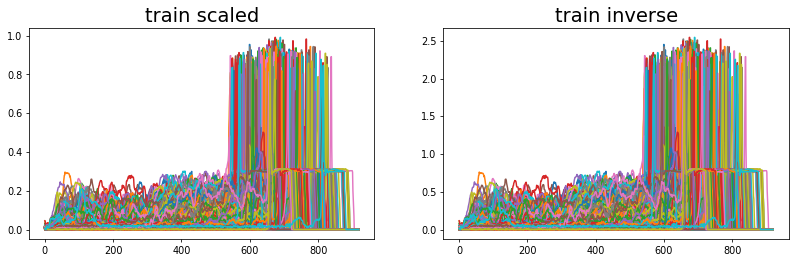

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=70)
axs[0].plot(x_train.transpose())
axs[1].plot(x_train_inverse.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("train inverse", fontsize=20)
fig.show()

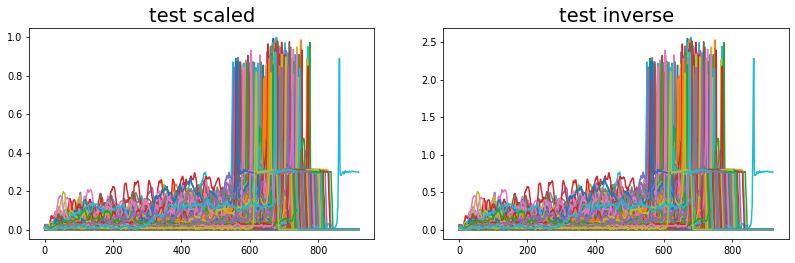

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=70)
axs[0].plot(x_test.transpose())
axs[1].plot(x_test_inverse.transpose())

axs[0].set_title("test scaled", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
fig.show()

In [13]:
y_test_converted = np.argmax(y_test, axis=1)
y_test_converted

array([4, 6, 2, 4, 4, 7, 0, 7, 0, 1, 0, 5, 3, 2, 5, 7, 7, 4, 4, 7, 7, 3,
       3, 0, 2, 0, 0, 5, 4, 6, 7, 4, 2, 6, 6, 2, 1, 0, 0, 6, 4, 7, 6, 3,
       6, 6, 3, 6, 2, 5, 3, 7, 6, 6, 6, 4, 2, 5, 5, 7, 1, 0, 5, 3, 4, 2,
       0, 3, 7, 2, 6, 0, 6, 2, 3, 6, 1, 7, 6, 3, 5, 4, 6, 4, 4, 5, 7, 4,
       3, 1, 6, 1, 5, 2, 5, 3, 1, 3, 7, 4, 3, 6, 7, 6, 6, 7, 4, 6, 4, 2,
       7, 6, 1, 4, 3, 2, 1, 4, 4, 4, 6, 3, 0, 2, 7, 6, 3, 3, 1, 7, 1, 1,
       0, 1, 1, 0, 4, 0, 4, 5, 2, 7, 5, 7, 1, 6, 2, 0, 2, 3, 4, 5, 1, 1,
       7, 3, 3, 5, 5, 2, 1, 0, 2, 0, 6, 5, 3, 1, 3, 0, 2, 3, 2, 6, 1, 3,
       5, 1, 7, 5, 6, 4, 4, 5, 0, 2, 6, 4, 1, 3, 0, 1, 2, 4, 7, 4, 4, 7,
       2, 4, 4, 4, 5, 4, 7, 2, 4, 2, 5, 6, 3, 2, 3, 5, 5, 0, 1, 2, 1, 2,
       7, 0, 6, 3, 2, 3, 1, 1, 7, 4, 1, 6, 4, 7, 1, 6, 4, 0, 1, 3, 6, 6,
       6, 0, 5, 6, 2, 0, 0, 0, 5, 4, 2, 4, 4, 5, 3, 5, 6, 1, 3, 5, 4, 3,
       6, 6, 7, 6, 1, 2, 4, 0, 7, 1, 6, 2, 7, 6, 3, 6, 0, 3, 0, 7, 5, 4,
       2, 4, 5, 0, 2, 6, 1, 3, 4, 1, 7, 4, 2, 0, 0,

In [14]:
unique, counts = np.unique(y_test_converted, return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 46, 2: 45, 3: 53, 4: 62, 5: 46, 6: 57, 7: 41}

In [15]:
# reshape train data in 3 dimensinal shape
len_curve = feature.shape[1]
print(len_curve)

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)

920


## 3. Searching optimal 1D-CNN structure

In [37]:
testing_structure = {"conv":[1], "maxpool":[[0,0,0,0,0]], "bn_conv":[[0,0,0,0,0]], "dropout_conv":[[0,0,0,0,0]], 
                     "dense":[0], "bn_dense":[[0,0,0,0,0]], "dropout_dense":[[0,0,0,0,0]]}

In [55]:
# control panel: testing the cnn model structure

for i in tq(drop):
    testing_structure = {"conv":[3], "maxpool":[[1,1,1,1]], 
                         "bn_conv":[[0,1,0,0]], "dropout_conv":[[0,0,1,0]], 
                         "dense":[2], "bn_dense":[[0,0,0,0]], "dropout_dense":[i]}

    cu.cnn_structure_optimization(testing_structure, x_train, y_train, epochs=40, batch_size=10)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START bn_conv=[0, 1, 0, 0], bn_dense=[0, 0, 0, 0], conv=3, dense=2, dropout_conv=[0, 0, 1, 0], dropout_dense=[1, 0, 0, 0], maxpool=[1, 1, 1, 1]
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_228 (Conv1D)         (None, 913, 32)           288       
                                                                 
 max_pooling1d_228 (MaxPooli  (None, 304, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_229 (Conv1D)         (None, 297, 32)           8224      
                                                                 
 max_pooling1d_229 (MaxPooli  (None, 99, 32)           0         
 ng1D)                                                           
                                  

 max_pooling1d_233 (MaxPooli  (None, 30, 32)           0         
 ng1D)                                                           
                                                                 
 dropout_116 (Dropout)       (None, 30, 32)            0         
                                                                 
 flatten_71 (Flatten)        (None, 960)               0         
                                                                 
 dense_213 (Dense)           (None, 80)                76880     
                                                                 
 dropout_117 (Dropout)       (None, 80)                0         
                                                                 
 dense_214 (Dense)           (None, 80)                6480      
                                                                 
 dense_215 (Dense)           (None, 8)                 648       
                                                                 
Total para

Epoch 3/40
96/96 [==============================] - 1s 9ms/step - loss: 0.2008 - accuracy: 0.9323
Epoch 4/40
96/96 [==============================] - 1s 8ms/step - loss: 0.1572 - accuracy: 0.9500
Epoch 5/40
96/96 [==============================] - 1s 9ms/step - loss: 0.1303 - accuracy: 0.9615
Epoch 6/40
96/96 [==============================] - 1s 8ms/step - loss: 0.1414 - accuracy: 0.9542
Epoch 7/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0903 - accuracy: 0.9688
Epoch 8/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0878 - accuracy: 0.9708
Epoch 9/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0758 - accuracy: 0.9708
Epoch 10/40
96/96 [==============================] - 1s 9ms/step - loss: 0.0697 - accuracy: 0.9771
Epoch 11/40
96/96 [==============================] - 1s 9ms/step - loss: 0.0930 - accuracy: 0.9698
Epoch 12/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0684 - accuracy: 0.9760
Epoch 13/40
96/96

96/96 [==============================] - 1s 8ms/step - loss: 0.0418 - accuracy: 0.9875
Epoch 32/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0080 - accuracy: 0.9990
Epoch 33/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0088 - accuracy: 0.9969
Epoch 34/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 35/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0179 - accuracy: 0.9958
Epoch 36/40
96/96 [==============================] - 1s 9ms/step - loss: 0.0084 - accuracy: 0.9990
Epoch 37/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0081 - accuracy: 0.9969
Epoch 38/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0097 - accuracy: 0.9958
Epoch 39/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0839 - accuracy: 0.9802
Epoch 40/40
24/24 [==============================] - 0s 5ms/step - loss: 0.1270 - accuracy: 0.9750
[CV 5/5; 1/1] END bn_c

                                                                 
 max_pooling1d_246 (MaxPooli  (None, 304, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_247 (Conv1D)         (None, 297, 32)           8224      
                                                                 
 max_pooling1d_247 (MaxPooli  (None, 99, 32)           0         
 ng1D)                                                           
                                                                 
 batch_normalization_81 (Bat  (None, 99, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_248 (Conv1D)         (None, 92, 32)            8224      
                                                                 
 max_pooling1d_248 (MaxPooli  (None, 30, 32)           0         
 ng1D)    

                                                                 
 dense_232 (Dense)           (None, 80)                6480      
                                                                 
 dropout_129 (Dropout)       (None, 80)                0         
                                                                 
 dense_233 (Dense)           (None, 8)                 648       
                                                                 
Total params: 100,872
Trainable params: 100,808
Non-trainable params: 64
_________________________________________________________________
None
Epoch 1/40
96/96 [==============================] - 2s 9ms/step - loss: 0.9004 - accuracy: 0.6927
Epoch 2/40
96/96 [==============================] - 1s 9ms/step - loss: 0.3077 - accuracy: 0.8885
Epoch 3/40
96/96 [==============================] - 1s 9ms/step - loss: 0.1574 - accuracy: 0.9479
Epoch 4/40
96/96 [==============================] - 1s 9ms/step - loss: 0.1931 - accuracy: 0.9396
Ep

96/96 [==============================] - 1s 8ms/step - loss: 0.0390 - accuracy: 0.9885
Epoch 23/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0281 - accuracy: 0.9896
Epoch 24/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0294 - accuracy: 0.9896
Epoch 25/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0237 - accuracy: 0.9927
Epoch 26/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0151 - accuracy: 0.9969
Epoch 27/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0207 - accuracy: 0.9927
Epoch 28/40
96/96 [==============================] - 1s 9ms/step - loss: 0.0079 - accuracy: 0.9979
Epoch 29/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 30/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 31/40
96/96 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 32/40
96/96 [===

### read db_cnn_structure file and convert it into a dataframe

In [16]:
#searching results are saved in json file
#loading the file and transform it into a dataframe

with open("results/cnn_structure_optimization_v4.1.json", "r") as f:
    file = json.load(f)
    
#for i in range(0, len(file), 2):
#    print(f"{file[i]}, {file[i+1]}")
    
dfcnn = pd.DataFrame(file[::2])
dfcnn["conv"] = dfcnn["conv"].str[0]
dfcnn["maxpool"] = dfcnn["maxpool"].str[0].astype(str)
dfcnn["bn_conv"] = dfcnn["bn_conv"].str[0].astype(str)
dfcnn["dropout_conv"] = dfcnn["dropout_conv"].str[0].astype(str)
dfcnn["dense"] = dfcnn["dense"].str[0]
dfcnn["bn_dense"] = dfcnn["bn_dense"].str[0].astype(str)
dfcnn["dropout_dense"] = dfcnn["dropout_dense"].str[0].astype(str)
dfcnn["mean_cv_acc"] = file[1::2]
dfcnn

,conv,maxpool,bn_conv,dropout_conv,dense,bn_dense,dropout_dense,mean_cv_acc
0,1,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.918333
1,2,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.941667
2,3,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.950000
3,4,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.946667
4,1,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.932500
5,2,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.957500
6,3,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.960000
7,4,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.950833
8,3,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",1,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.969167
9,3,"[1, 1, 1, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",2,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.970000


In [140]:
benchmark = dfcnn.iloc[9]
benchmark

conv                        3
maxpool          [1, 1, 1, 1]
bn_conv          [0, 0, 0, 0]
dropout_conv     [0, 0, 0, 0]
dense                       2
bn_dense         [0, 0, 0, 0]
dropout_dense    [0, 0, 0, 0]
mean_cv_acc              0.97
Name: 9, dtype: object

## 4. Visualization of the searching results

In [17]:
conv_wo_maxpool = np.round(dfcnn.iloc[0:4]["mean_cv_acc"].values, 3)
conv_wo_maxpool

array([0.918, 0.942, 0.95 , 0.947])

In [18]:
conv_w_maxpool = np.round(dfcnn.iloc[4:8]["mean_cv_acc"].values, 3)
conv_w_maxpool

array([0.933, 0.957, 0.96 , 0.951])

In [61]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


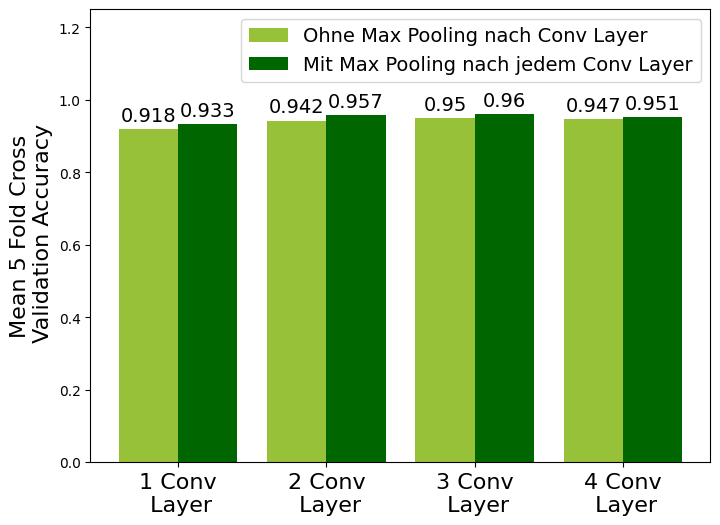

In [63]:
cu.grouped_barplot(leftlist=conv_wo_maxpool, leftlabel='Ohne Max Pooling nach Conv Layer', leftcolor=fapsc.green, 
                   rightlist=conv_w_maxpool, rightlabel='Mit Max Pooling nach jedem Conv Layer', rightcolor=fapsc.dark_green, 
                   title='', 
                   xtickslist=[f"1 Conv\n Layer", f"2 Conv\n Layer", f"3 Conv\n Layer", f"4 Conv\n Layer"],
                   size=(8,6))

In [27]:
cnn3_dense = dfcnn.iloc[8:12]["mean_cv_acc"].values
cnn3_dense = np.insert(cnn3_dense, 0, dfcnn.iloc[6]["mean_cv_acc"])  #nur 3 conv layer
cnn3_dense = np.round(cnn3_dense, 3)
cnn3_dense

array([0.96 , 0.969, 0.97 , 0.967, 0.969])

In [58]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


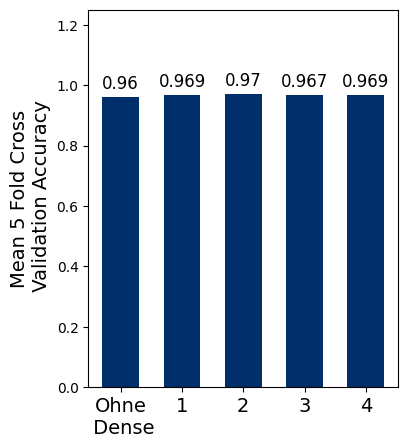

In [64]:
cu.single_barplot(values=cnn3_dense, valuecolor=fapsc.blue, title=f"", 
                  xtickslist=[f"Ohne\n Dense", f"1", f"2", 
                              f"3", f"4"],
                  size=(4,5), width=0.6, rotation=0)

In [65]:
batchnorm = np.round(dfcnn.iloc[12:19]["mean_cv_acc"].values, 3)
batchnorm = np.insert(batchnorm, 0, dfcnn.iloc[9]["mean_cv_acc"])
batchnorm 

array([0.97 , 0.961, 0.972, 0.968, 0.942, 0.966, 0.902, 0.968])

In [79]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


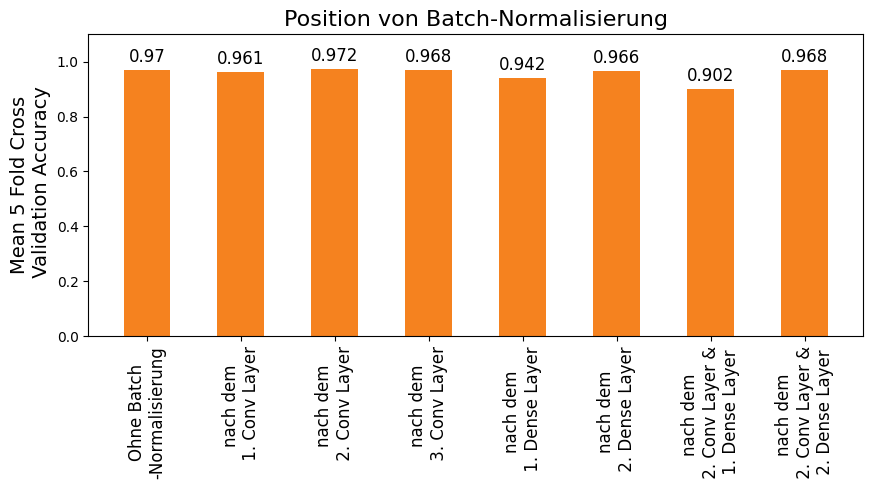

In [85]:
cu.single_barplot(values=batchnorm, valuecolor=fapsc.orange, title='Position von Batch-Normalisierung', 
                  xtickslist=[f"Ohne Batch\n-Normalisierung", f"nach dem\n 1. Conv Layer", f"nach dem\n 2. Conv Layer",
                              f"nach dem\n 3. Conv Layer", 'nach dem\n 1. Dense Layer', 'nach dem\n 2. Dense Layer',
                              f"nach dem\n 2. Conv Layer &\n 1. Dense Layer", f"nach dem\n 2. Conv Layer &\n 2. Dense Layer"],
                  size=(10,4), width=0.5, rotation=90, ylim=1.1)

In [68]:
dropout = dfcnn.iloc[20:28]["mean_cv_acc"].values
dropout = np.insert(dropout, 0, dfcnn.iloc[13]["mean_cv_acc"])
dropout = np.round(dropout, 3)
dropout

array([0.972, 0.969, 0.97 , 0.971, 0.97 , 0.966, 0.945, 0.965, 0.963])

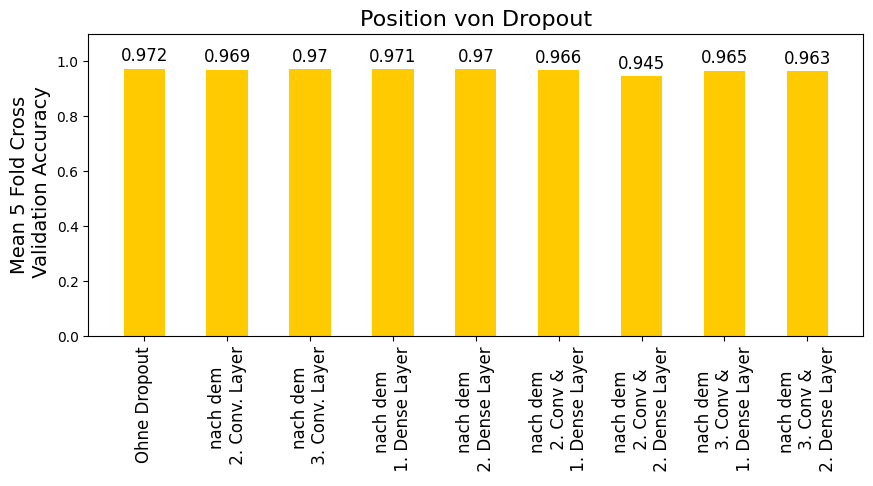

In [86]:
cu.single_barplot(values=dropout, valuecolor=fapsc.yellow, 
                  title='Position von Dropout', 
                  xtickslist=[f"Ohne Dropout", f"nach dem\n 2. Conv. Layer", f"nach dem\n 3. Conv. Layer",
                              f"nach dem\n 1. Dense Layer", f"nach dem\n 2. Dense Layer",
                              f"nach dem\n 2. Conv &\n 1. Dense Layer", f"nach dem\n 2. Conv &\n 2. Dense Layer",
                              f"nach dem\n 3. Conv &\n 1. Dense Layer", f"nach dem\n 3. Conv &\n 2. Dense Layer"],
                   size=(10,4), width=0.5, rotation=90, ylim=1.1)